**Programming Assignment E0_298**

In [84]:
import numpy as np
import time 
import matplotlib.pyplot as plt 
from tqdm import tqdm # progress bar
import os
import pickle

### Question 1 Regression

In [3]:
# Implement a Data Loader Class
def load_data(file_path):
    with open(file_path) as f:
        data_string = f.readlines()

        # Extracting the number of input and output features from the first line
        input_features, output_features = map(int, data_string[0].strip().split())
        data = []  # This will hold all the data points

        # Iterating through each line of data starting from the second line
        for i in range(1, len(data_string)):
            line = data_string[i].strip().split(',')  # Splitting each line by comma
            line_data = [float(value) for value in line]  # Converting each item to float
            data.append(line_data)  # Appending to data list

    # Separating input and output features
    input_data = np.array([d[:input_features] for d in data])  # Slicing input features
    output_data = np.array([d[input_features:] for d in data])  # Slicing output features
    
    return input_data, output_data  # Returning input and output features

# Function to calculate Pearson Correlation
def train_test_split(X,Y,test_size=0.2):
    """
    Split the data into training and testing sets.
    """
    # Calculate the number of samples for the test set
    test_samples = int(test_size * len(X))
    
    # Randomly shuffle the indices of the data
    indices = np.random.permutation(X.shape[0])
    
    # Split the indices into training and test sets
    training_idx, test_idx = indices[test_samples:], indices[:test_samples]
    
    # Create the training and test sets
    X_train, X_test = X[training_idx], X[test_idx]
    Y_train, Y_test = Y[training_idx], Y[test_idx]
    
    return X_train, X_test, Y_train, Y_test

   
# Function to calculate Pearson Correlation
def pearson_correlation(y_true, y_pred):
    """
    Computes the Pearson Correlation Coefficient between y_true and y_pred.
    """
    # Flatten arrays in case of multi-dimensional inputs
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Calculate means of y_true and y_pred
    mean_y_true = np.mean(y_true)
    mean_y_pred = np.mean(y_pred)
    
    # Calculate the numerator and denominator for Pearson correlation
    numerator = np.sum((y_true - mean_y_true) * (y_pred - mean_y_pred))
    denominator = np.sqrt(np.sum((y_true - mean_y_true) ** 2)) * np.sqrt(np.sum((y_pred - mean_y_pred) ** 2))
    
    # Avoid division by zero
    if denominator == 0:
        return 0
    
    return numerator / denominator


In [4]:
# Prediction function
def predict(X, W, degree=1):
    """
    Predicts the output Y given input X and weights W.
    """
    if degree > 1:
        X = np.hstack([X**d for d in range(1, degree+1)])
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # Add bias term
    return X @ W

# Calculate Metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculates Pearson Correlation, Mean Squared Error, and Mean Absolute Error.
    """
    # Calculate Pearson Correlation
    pearson_corr = pearson_correlation(y_true.flatten(), y_pred.flatten())  # Flatten in case of multi-dimensional targets

    # Calculate MSE and MAE
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))

    return pearson_corr, mse, mae

# Plot Correlation
def plot_correlation(y_true, y_pred, title):
    """
    Plots the correlation between true and predicted values.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=1)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.show()


### 1.1 Multilinear Regression and Polynomial Regression

In [139]:
def linear_regression(X, Y):
    """
    Performs Multilinear Regression.
    Finds the weights that best fit Y = XW in the least-squares sense.
    """
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # Add bias term
    W = np.linalg.pinv(X.T @ X) @ X.T @ Y  # Normal equation for linear regression
    return W

Multilinear Regression Metrics:
Pearson Correlation: 0.9999, MSE: 0.0400, MAE: 0.1597


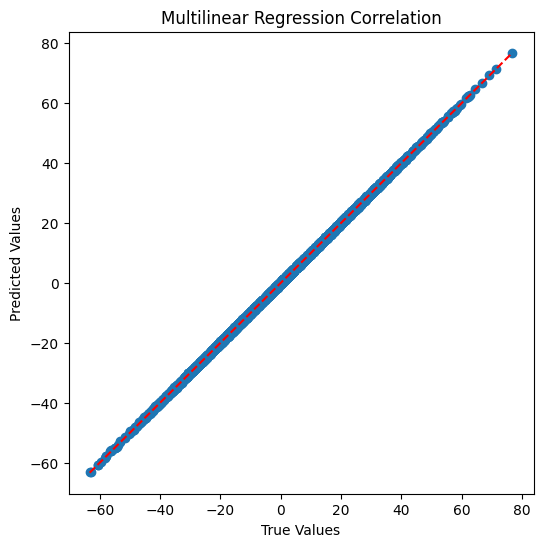

In [185]:
X_multilinear, Y_multilinear = load_data('Data/regression_data_057.txt') # Load the data
# Split the data into training and testing sets
X_multilinear_train,X_multilinear_test,Y_multilinear_train,Y_multilinear_test = train_test_split(X_multilinear, Y_multilinear, test_size=0.2)
# Multilinear Regression
W_multilinear = linear_regression(X_multilinear_train, Y_multilinear_train)
Y_pred_multilinear = predict(X_multilinear_test, W_multilinear)
print("Multilinear Regression Metrics:")
pearson_corr_multi, mse_multi, mae_multi = calculate_metrics(Y_multilinear_test, Y_pred_multilinear)
print(f"Pearson Correlation: {pearson_corr_multi:.4f}, MSE: {mse_multi:.4f}, MAE: {mae_multi:.4f}")

# Plot correlation for Multilinear Regression
plot_correlation(Y_multilinear_test, Y_pred_multilinear, "Multilinear Regression Correlation")


### Observations
- **Perfect Alignment**: The predicted values align almost perfectly along the red dashed line, indicating a near-ideal 1:1 relationship between the true and predicted values. This close alignment shows that the model’s predictions closely match the actual values across the entire range.

- **Extremely High Pearson Correlation**: The near-perfect alignment suggests a Pearson Correlation close to 1, meaning the model has captured the linear relationship in the data exceptionally well.

- **Low Error Metrics**: The tight clustering of points along the red line implies very low Mean Squared Error (MSE) and Mean Absolute Error (MAE), indicating minimal deviation between the predicted and true values.

- **Robustness Across Data Range**: The accuracy of predictions across both positive and negative values (approximately -80 to 80) demonstrates that the model generalizes well across the dataset without significant biases or errors in any specific regions.

### Overall Summary
The multilinear regression model performs exceptionally well, capturing the linear relationship between input features and target values with high accuracy. The near-perfect alignment along the red dashed line demonstrates that the model provides reliable predictions with minimal error, making it highly suitable for this dataset.







In [7]:
def polynomial_regression(X, Y, degree):
    """
    Performs Polynomial Regression.
    Finds the weights that best fit Y = X^degree W in the least-squares sense.
    """
    X = np.hstack([X**d for d in range(1, degree+1)])  # Add polynomial terms
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # Add bias term
    W = np.linalg.pinv(X.T @ X) @ X.T @ Y  # Normal equation for linear regression
    return W

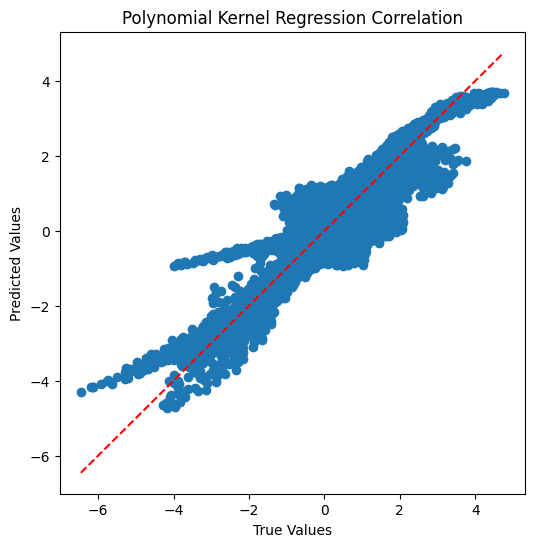

Polynomial Kernel Regression - MSE: 0.3574734147244475 MAE: 0.43354602486412036 Pearson Correlation: 0.9333861954039768


In [8]:
# Load data for Polynomial Kernel Regression
X_poly, Y_poly = load_data('Data/poly_regression_data_057.txt')
X_poly_train, X_poly_test, Y_poly_train, Y_poly_test = train_test_split(X_poly, Y_poly, test_size=0.5)
# Perform Polynomial Kernel Regression (degree 2 by default)
W_poly = polynomial_regression(X_poly_train, Y_poly_train, degree=2)
Y_pred_poly = predict(X_poly_test, W_poly, degree=2)
pearson_coeff,mse_poly, mae_poly = calculate_metrics(Y_poly_test, Y_pred_poly)

# Plot correlation for Polynomial Kernel Regression
plot_correlation(Y_poly_test, Y_pred_poly, "Polynomial Kernel Regression Correlation")

# Print metrics for Polynomial Kernel Regression
print("Polynomial Kernel Regression - MSE:", mse_poly, "MAE:", mae_poly, "Pearson Correlation:", pearson_coeff)

**Experiments**

### Observations

- The high **Pearson Correlation** suggests that the model captures the trend in the data well, demonstrating a strong linear relationship between predictions and actual values.
  
- Both **MSE** and **MAE** values, while not zero, are relatively low, indicating that the model's predictions are reasonably accurate.

- Overall, these metrics suggest that the polynomial regression model with a kernel performs well on this dataset, capturing the relationship with a relatively high level of accuracy. However, there may still be room for further improvement if even smaller errors are desired.
 -Observations Based on Polynomial Kernel Regression Correlation Plot
 Strong Positive Trend:
-The scatter plot shows a clear positive trend, indicating that the predicted values generally increase with the true values. This trend aligns well with the dashed red line, which represents an ideal 1:1 correlation.
- Good Fit with Some Variability:
Although most points are close to the red line, there is some spread around it, particularly as the values become more extreme (both positive and negative). This spread suggests that while the model captures the overall trend, it might struggle with capturing finer details or more extreme values accurately.
- Outliers and Wider Spread:
The plot shows some points that deviate from the main cluster, especially in the lower-left and upper-right areas. These outliers may indicate cases where the model's predictions differ significantly from the actual values, potentially due to nonlinearities or complex patterns that the polynomial kernel is unable to capture perfectly.


### 1.2 Adding Linear Constraints 

### Constrained Linear Regression

In [136]:
def constrained_linear_regression(X, Y, A, b):
    """
    Solves the linear regression problem with linear constraints A W_rest = b,
    excluding constraints on the bias term.
    
    Parameters:
    X (numpy.ndarray): Feature matrix.
    Y (numpy.ndarray): Target matrix.
    A (numpy.ndarray): Constraint coefficient matrix (excludes bias constraints).
    b (numpy.ndarray): Constraint vector.
    
    Returns:
    numpy.ndarray: Weight vector W (including bias term).
    """
    # Add bias term to the feature matrix
    X_aug = np.hstack([np.ones((X.shape[0], 1)), X])  # Augmented feature matrix with bias term
    
    # Compute key matrices
    XTX = X_aug.T @ X_aug
    XTY = X_aug.T @ Y
    XTX_inv = np.linalg.inv(XTX)
    
    # Compute unconstrained weights
    W_unconstrained = XTX_inv @ XTY
    
    # Extract submatrices for constraints
    XTX_rest_inv = np.linalg.inv(XTX[1:, 1:])  # Exclude bias from inversion
    XTY_rest = XTY[1:]  # Exclude bias from target multiplication
    W_rest_unconstrained = XTX_rest_inv @ XTY_rest  # Unconstrained weights for non-bias terms
    
    # Compute constraint adjustment
    A_XTX_rest_inv = A @ XTX_rest_inv
    adjustment = np.linalg.inv(A_XTX_rest_inv @ A.T) @ (A_XTX_rest_inv @ XTY_rest - b)
    W_rest_constrained = W_rest_unconstrained - XTX_rest_inv @ A.T @ adjustment
    
    # Combine bias and constrained weights
    W_constrained = np.zeros(W_unconstrained.shape)
    W_constrained[0] = W_unconstrained[0]  # Set bias term
    W_constrained[1:] = W_rest_constrained  # Set constrained weights
    
    return W_constrained


Constrained Multilinear Regression Metrics:
Pearson Correlation: 0.7115, MSE: 184.5419, MAE: 10.5465


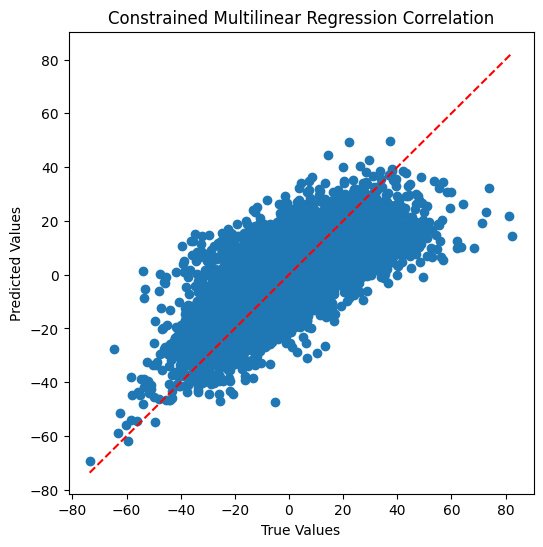

In [189]:
# Load data and constraints
X_multilinear, Y_multilinear = load_data('Data/regression_data_057.txt')  # Path to data file
A, b = load_constraints('Data/constraints_057.txt')  # Load constraints

b = np.tile(b, (3, 1))  # Repeat `b` to get a 3x3 matrix
  

# Split the data into training and testing sets
X_multilinear_train, X_multilinear_test, Y_multilinear_train, Y_multilinear_test = train_test_split(
    X_multilinear, Y_multilinear, test_size=0.2
)

# Initialize `W_constrained` as (10+1, 3) to include bias and match with the constraint matrix
W_constrained = np.zeros((X_multilinear_train.shape[1] + 1, b.shape[1]))  # Initialize W as (11, 3)

# Solve the constrained regression problem for each output dimension
for i in range(b.shape[1]):
    # Solve for each column of W with the corresponding column in b
    W_constrained[:, i] = constrained_linear_regression(X_multilinear_train, Y_multilinear_train[:, i], A, b[:, i])

# Make predictions on the test set
Y_pred_constrained = predict(X_multilinear_test, W_constrained)

# Evaluate metrics
print("Constrained Multilinear Regression Metrics:")
pearson_corr_constrained, mse_constrained, mae_constrained = calculate_metrics(Y_multilinear_test, Y_pred_constrained)
print(f"Pearson Correlation: {pearson_corr_constrained:.4f}, MSE: {mse_constrained:.4f}, MAE: {mae_constrained:.4f}")

# Plot correlation
plot_correlation(Y_multilinear_test, Y_pred_constrained, "Constrained Multilinear Regression Correlation")


### Constrained Linear Regression using Lagrangian Method (Latex code not Rendering..)

#### Problem Statement:
1. **Objective**:
   \[
   \min_{W} \|XW - Y\|_2^2
   \]
   - \( X \): Feature matrix (\( n \times d \)),
   - \( Y \): Target matrix (\( n \times m \)),
   - \( W \): Weight matrix (\( d \times m \)).

2. **Constraints**:
   \[
   A W_{\text{rest}} = b
   \]
   - \( A \): Constraint matrix (\( k \times (d-1) \)),
   - \( b \): Constraint vector (\( k \times m \)).

---

#### Lagrangian Formulation:
To incorporate the constraints into the optimization problem, we define the Lagrangian as:
\[
\mathcal{L}(W, \Lambda) = \|XW - Y\|_2^2 + \Lambda^T (A W_{\text{rest}} - b)
\]

---

#### Solution:
1. **Stationary Conditions**:
   - Gradient with respect to \( W \):
     \[
     \frac{\partial \mathcal{L}}{\partial W} = X^T X W + \frac{1}{2} A^T \Lambda = X^T Y
     \]
   - Gradient with respect to \( \Lambda \):
     \[
     \frac{\partial \mathcal{L}}{\partial \Lambda} = A W_{\text{rest}} - b = 0
     \]

2. **Solve for \( \Lambda \)**:
   Solve the equation:
   \[
   \Lambda = \left(A (X^T X)^{-1} A^T \right)^{-1} \left(b - A (X^T X)^{-1} X^T Y \right)
   \]

3. **Final Solution for \( W_{\text{rest}} \)**:
   Substitute \( \Lambda \) to compute \( W_{\text{rest}} \):
   \[
   W_{\text{rest}} = (X^T X)^{-1} X^T Y - (X^T X)^{-1} A^T \Lambda
   \]

4. **Combine Bias and Constrained Weights**:
   The final weight matrix \( W \) is:
   \[
   W = \begin{bmatrix} W_0 \\ W_{\text{rest}} \end{bmatrix}
   \]
   where \( W_0 \) is the bias term obtained from the unconstrained least-squares solution.


### Question 2 Principal Component Analysis on Mnist and Cifar-10

In [33]:
def load_mnist_csv(file_path):
    """ Loads the MNIST dataset from a CSV file."""
    data = np.loadtxt(file_path, delimiter=',', dtype=np.float64)
    labels = data[:, 0].astype(int)  # Extract labels (first column)
    images = data[:, 1:]  # Extract pixel values
    images /= 255.0  # Normalize pixel values to [0, 1] range
    return images, labels

def compute_psnr(original, reconstructed, data_range=1.0):
    """
    Computes Peak Signal-to-Noise Ratio (PSNR) between original and reconstructed images.
    
    """
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')  # Infinite PSNR for perfect reconstruction
    psnr_value = 20 * np.log10(data_range / np.sqrt(mse))
    return psnr_value


In [39]:

# PCA Pipeline for Image Reconstruction

# Standardize Data
def standardize_data(X):
    """
    Centers the data matrix by subtracting the mean.
    """
    mean = np.mean(X, axis=0)
    X_centered = X - mean
    return X_centered, mean

# Compute PCA using Eigen Decomposition
def compute_pca_eigen(X, n_components):
    """
    Performs PCA by computing the eigen decomposition of the covariance matrix.
    Returns the top n_components principal components and the explained variance ratios.
    """
    # Compute the covariance matrix
    covariance_matrix = np.cov(X, rowvar=False)
    
    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the top n_components
    principal_components = eigenvectors[:, :n_components]
    explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
    
    return principal_components, explained_variance_ratio

# Project Data onto Principal Components
def project_data(X, components):
    """
    Projects the data X onto the given principal components.
    """
    return X @ components

# Reconstruct Images
def reconstruct_images(X_projected, components, mean):
    """
    Reconstructs images from the projected data using the principal components.
    """
    return (X_projected @ components.T) + mean

# Visualization of Original and Reconstructed Images
def visualize_reconstructions(original_images, reconstructed_images, n_images=10, image_shape=(28, 28)):
    """
    Displays original and reconstructed images side-by-side.
    """
    plt.figure(figsize=(10, 4))
    for i in range(n_images):
        # Original image
        plt.subplot(2, n_images, i + 1)
        plt.imshow(original_images[i].reshape(image_shape), cmap='gray')
        plt.axis('off')
        # Reconstructed image
        plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructed_images[i].reshape(image_shape), cmap='gray')
        plt.axis('off')
    plt.show()

# Visualize 1 images from each class
def visualize_reconstructions_per_class(X_original, X_reconstructed, y, image_shape=(28, 28)):
    """
    Visualizes original and reconstructed images, one for each class (0-9).
    
    """
    classes = np.unique(y)
    plt.figure(figsize=(10, 4))
    
    for i, cls in enumerate(classes):
        # Find the first occurrence of each class
        idx = np.where(y == cls)[0][0]

        # Original image
        plt.subplot(2, len(classes), i + 1)
        plt.imshow(X_original[idx].reshape(image_shape), cmap='gray')
        plt.axis('off')
        plt.title(f"Original: {cls}")

        # Reconstructed image
        plt.subplot(2, len(classes), i + 1 + len(classes))
        plt.imshow(X_reconstructed[idx].reshape(image_shape), cmap='gray')
        plt.axis('off')
        plt.title(f"Reconst.: {cls}")
    
    plt.tight_layout()
    plt.show()




### MNIST PCA : Experiments and Observations

Shape of X (Training Data): (60000, 784)
Shape of X_test (Test Data): (10000, 784)

Number of Principal Components: 10
Compression Ratio (Effective Size / Original Size): 0.012921768707482992
Training MSE: 0.03442260175516402 Training PSNR (dB): 14.631563075933398
Test MSE: 0.03407381609165851 Test PSNR (dB): 14.675792249662784
Total Explained Variance: 0.4881498035493392


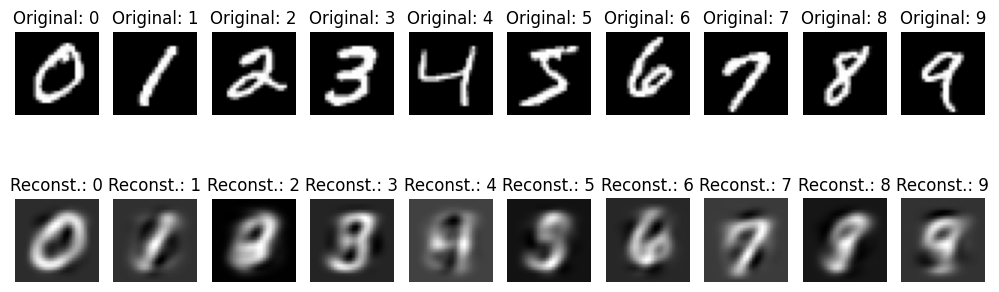

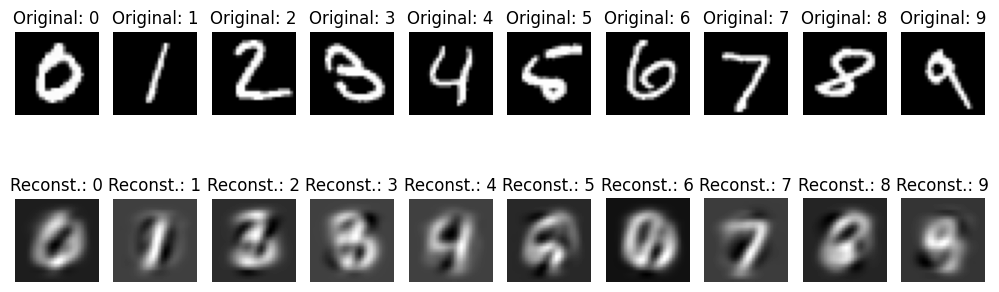


Number of Principal Components: 25
Compression Ratio (Effective Size / Original Size): 0.032304421768707486
Training MSE: 0.020726526942532998 Training PSNR (dB): 16.83473464720343
Test MSE: 0.02025942391331978 Test PSNR (dB): 16.933729081772903
Total Explained Variance: 0.691804908799958


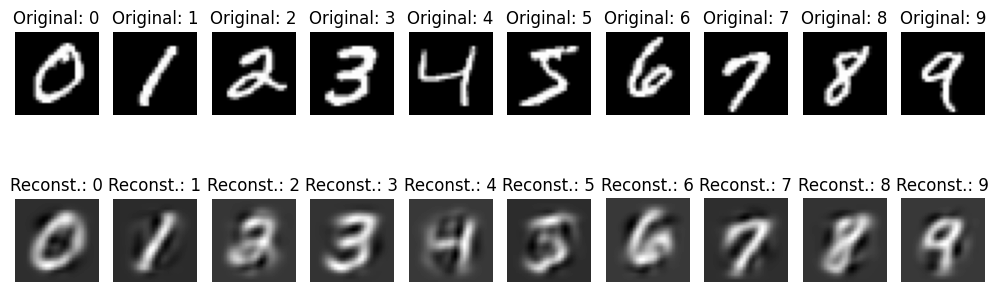

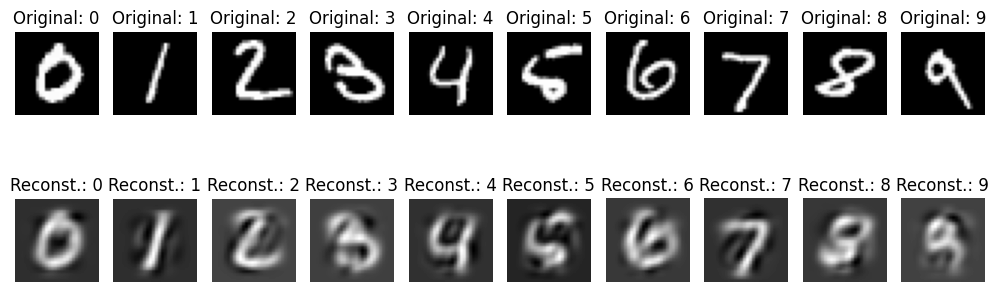


Number of Principal Components: 50
Compression Ratio (Effective Size / Original Size): 0.06460884353741497
Training MSE: 0.01179273004454656 Training PSNR (dB): 19.2838564307864
Test MSE: 0.011485018108189783 Test PSNR (dB): 19.398683157253156
Total Explained Variance: 0.824646863333467


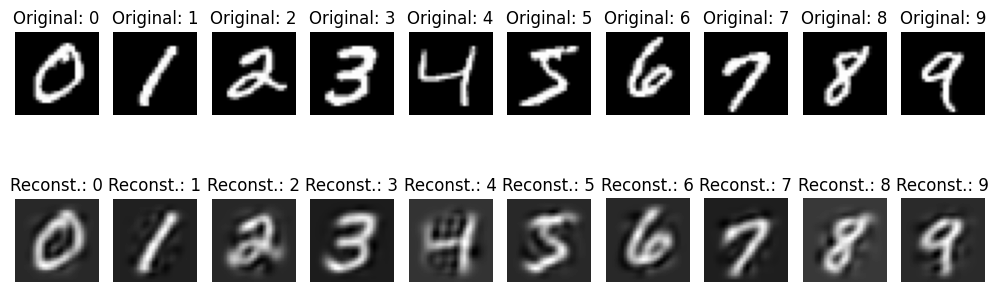

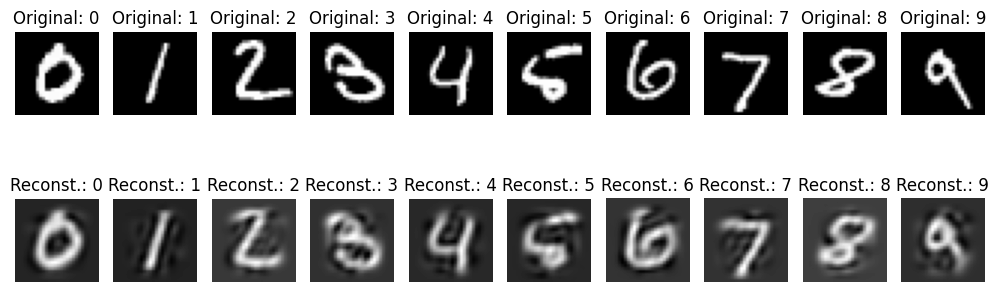


Number of Principal Components: 100
Compression Ratio (Effective Size / Original Size): 0.12921768707482995
Training MSE: 0.005741341260709955 Training PSNR (dB): 22.409866382502237
Test MSE: 0.00561586452487443 Test PSNR (dB): 22.505833775180545
Total Explained Variance: 0.9146285724394948


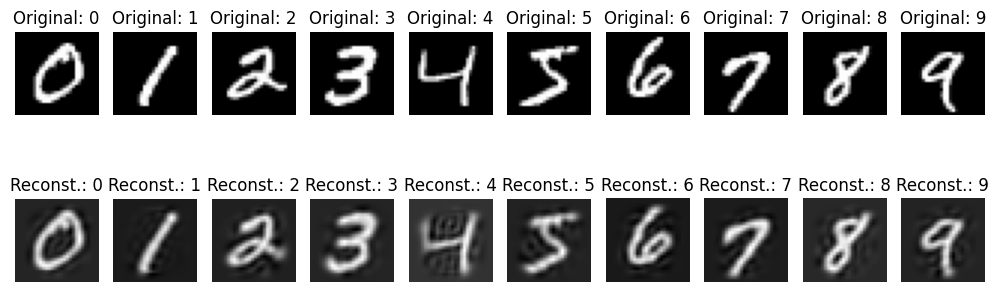

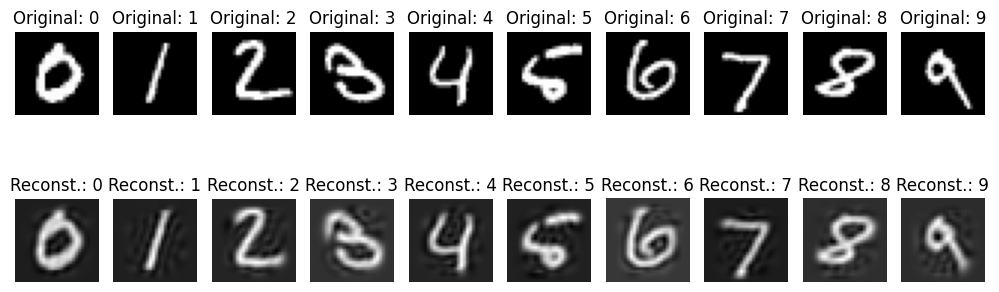


Number of Principal Components: 200
Compression Ratio (Effective Size / Original Size): 0.2584353741496599
Training MSE: 0.0022564601829306846 Training PSNR (dB): 26.46572325554452
Test MSE: 0.0022332898427669646 Test PSNR (dB): 26.510549092861023
Total Explained Variance: 0.9664473477010403


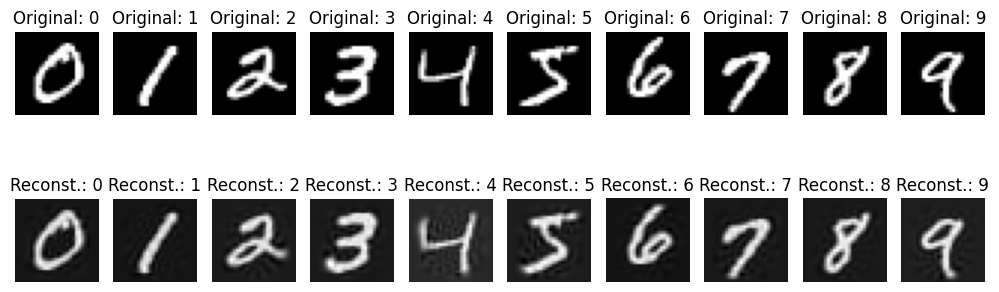

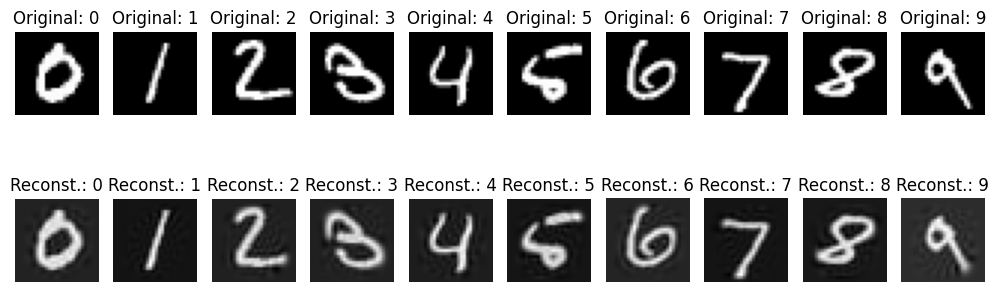


Number of Principal Components: 300
Compression Ratio (Effective Size / Original Size): 0.3876530612244898
Training MSE: 0.0009261349119112281 Training PSNR (dB): 30.333257441703203
Test MSE: 0.0009142799103222797 Test PSNR (dB): 30.389208229774095
Total Explained Variance: 0.9862287476125887


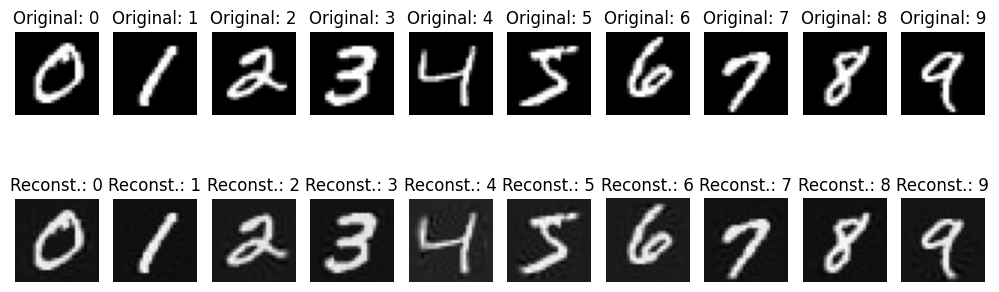

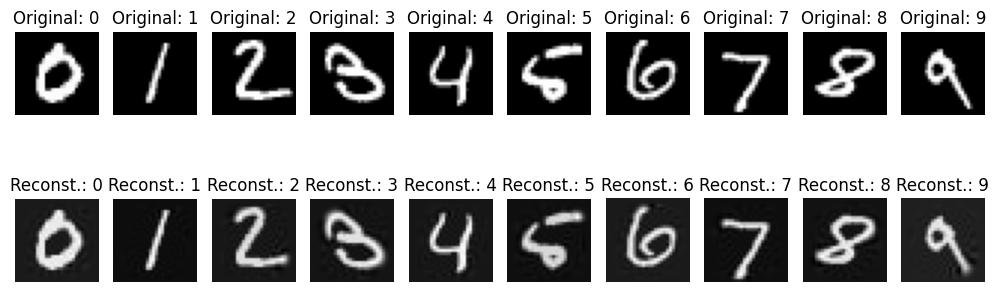

In [48]:
# Load MNIST dataset
X, Y = load_mnist_csv('MNIST_CSV/mnist_train.csv')
print("Shape of X (Training Data):", X.shape)  # Expected: (num_samples, 784)

# Load test set (assumes the first column is labels, followed by pixels)
X_test, Y_test = load_mnist_csv('MNIST_CSV/mnist_test.csv')
print("Shape of X_test (Test Data):", X_test.shape)  # Expected: (num_samples, 784)

# Varying the number of principal components
for n_components in [10, 25, 50, 100, 200, 300]:
    print(f"\nNumber of Principal Components: {n_components}")

    # Standardize the Training Data
    X_standardized, mean = standardize_data(X)

    # Perform PCA on Training Data
    principal_components, explained_variance_ratio = compute_pca_eigen(X_standardized, n_components)

    # Project Training Data onto Principal Components
    X_projected = project_data(X_standardized, principal_components)

    # Reconstruct Training Data from the Projected Data
    X_reconstructed = reconstruct_images(X_projected, principal_components, mean)

    # Standardize the Test Data using the mean from Training Data
    X_test_standardized = X_test - mean

    # Project Test Data onto the Principal Components from Training Data
    X_test_projected = project_data(X_test_standardized, principal_components)

    # Reconstruct Test Data from the Projected Data
    X_test_reconstructed = reconstruct_images(X_test_projected, principal_components, mean)

    # Calculate Compression Ratio for the Training Data
    size_original = X.nbytes
    size_effective = X_projected.nbytes + principal_components.nbytes  # Include principal components size for compression ratio
    compression_ratio = size_effective / size_original

    # Calculate Mean Squared Error for Training Data Reconstruction
    mse_train = np.mean((X - X_reconstructed) ** 2)
    psnr_train = compute_psnr(X, X_reconstructed, data_range=1.0)

    # Calculate Mean Squared Error for Test Data Reconstruction
    mse_test = np.mean((X_test - X_test_reconstructed) ** 2)
    psnr_test = compute_psnr(X_test, X_test_reconstructed, data_range=1.0)

    # Print Results
    print("Compression Ratio (Effective Size / Original Size):", compression_ratio)
    print("Training MSE:", mse_train, "Training PSNR (dB):", psnr_train)
    print("Test MSE:", mse_test, "Test PSNR (dB):", psnr_test)
    print("Total Explained Variance:", np.sum(explained_variance_ratio))

    # Visualize Reconstruction for Training Data (One from Each Class)
    visualize_reconstructions_per_class(X, X_reconstructed, Y, image_shape=(28, 28))
    visualize_reconstructions_per_class(X_test, X_test_reconstructed, Y_test, image_shape=(28, 28))

100%|██████████| 784/784 [00:56<00:00, 13.94it/s]


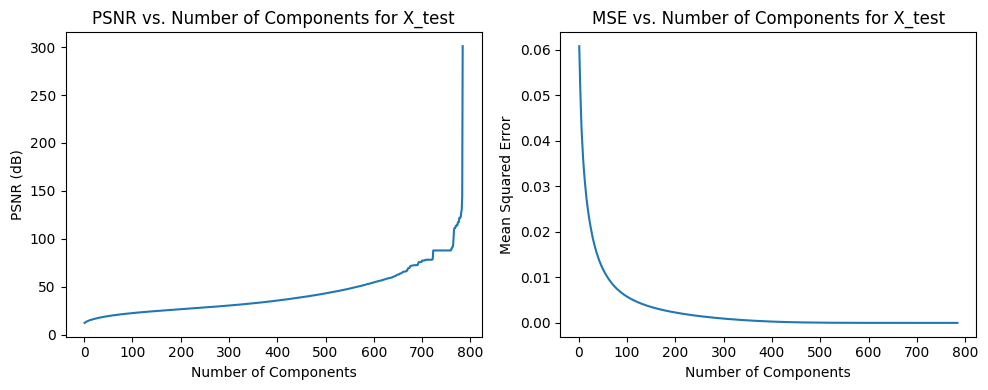

In [153]:
# Load and split MNIST Dataset into training and test sets
X, Y = load_mnist_csv('MNIST_CSV/mnist_train.csv')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Standardize Training and Test Data (using training mean for consistency)
X_train_standardized, mean = standardize_data(X_train)
X_test_standardized = X_test - mean  # Apply mean from training to test data

# Perform PCA once on the training data
full_principal_components, explained_variance_ratio = compute_pca_eigen(X_train_standardized, n_components=X_train.shape[1])

# Initialize lists to store PSNR and MSE values for X_test
psnr_values = []
mse_values = []

# Varying the number of principal components
for n_components in tqdm(range(1, 785)):

    # Select the top `n_components` principal components from the full PCA
    principal_components = full_principal_components[:, :n_components]

    # Project Test Data onto Principal Components
    X_test_projected = project_data(X_test_standardized, principal_components)  # Shape: (num_samples, n_components)

    # Reconstruct Test Images from the Projected Data
    X_test_reconstructed = reconstruct_images(X_test_projected, principal_components, mean)

    # Calculate Mean Squared Error for Test Data
    mse = np.mean((X_test - X_test_reconstructed) ** 2)
    mse_values.append(mse)

    # Calculate PSNR for Test Data
    psnr_value = compute_psnr(X_test, X_test_reconstructed, data_range=1.0)  # Assuming data normalized to [0, 1]
    psnr_values.append(psnr_value)

# Plot PSNR vs. Number of Components for X_test
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 785), psnr_values)
plt.xlabel("Number of Components")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs. Number of Components for X_test")

# Plot MSE vs. Number of Components for X_test
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 785), mse_values)
plt.xlabel("Number of Components")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs. Number of Components for X_test")

plt.tight_layout()
plt.show()


### CIFAR-10

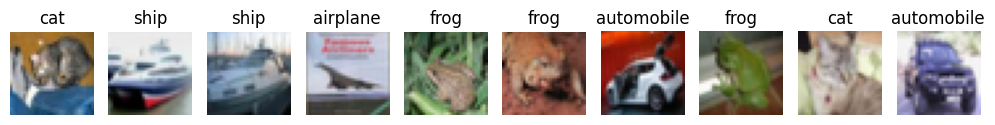

In [98]:
def load_cifar10_batch(file):
    with open(file, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (batch_size, 32, 32, 3)
        labels = np.array(labels)
    return images, labels

def load_cifar10_data(data_dir):
    train_images, train_labels = [], []
    for i in range(1, 6):
        file = os.path.join(data_dir, f"data_batch_{i}")
        images, labels = load_cifar10_batch(file)
        train_images.append(images)
        train_labels.append(labels)
    
    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)
    
    test_images, test_labels = load_cifar10_batch(os.path.join(data_dir, "test_batch"))
    
    return (train_images/255.0, train_labels), (test_images/255.0, test_labels)
#Load cifar10 data
Train_Data,Test_Data = load_cifar10_data('cifar-10-batches-py')
X_train, y_train = Train_Data
X_test, y_test = Test_Data  
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
visualize_cifar10(X_test, y_test, class_names, n_images=10)   

In [203]:


def reconstruct_images_cifar(original_images, reconstructed_images, labels, class_names, n_images=10):
    """
    Visualizes original and reconstructed CIFAR-10 images side by side.
    
    Args:
        original_images (np.ndarray): Original images.
        reconstructed_images (np.ndarray): Reconstructed images.
        labels (np.ndarray): Labels corresponding to the images.
        class_names (list): CIFAR-10 class names.
        n_images (int): Number of images to visualize.
    """
    plt.figure(figsize=(10, 8))
    for i in range(n_images):
        # Original image
        plt.subplot(2, n_images, i + 1)
        plt.imshow(original_images[i])
        # plt.title(f"Orig: {class_names[labels[i]]}")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(np.clip(reconstructed_images[i], 0, 1))  # Clip to [0, 1] range
        # plt.title(f"Reconst.")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
def visualize_one_image_per_class(original_images, reconstructed_images, labels, class_names, image_shape=(32, 32, 3)):
    """
    Visualizes one original and one reconstructed image per class (CIFAR-10 has 10 classes).
    
    Args:
        original_images: Array of original images.
        reconstructed_images: Array of reconstructed images.
        labels: Array of image labels.
        class_names: List of class names (10 for CIFAR-10).
        image_shape: Tuple representing the shape of the images (default is (32, 32, 3) for CIFAR-10).
    """
    classes = np.unique(labels)
    plt.figure(figsize=(10, 5))

    for i, cls in enumerate(classes):
        # Find the first occurrence of each class in the labels
        idx = np.where(labels == cls)[0][0]

        # Plot Original Image
        plt.subplot(2, len(classes), i + 1)
        plt.imshow(np.clip(original_images[idx].reshape(image_shape),0,1))
        plt.title(f"Original: {class_names[cls]}")
        plt.axis('off')

        # Plot Reconstructed Image
        plt.subplot(2, len(classes), i + 1 + len(classes))
        plt.imshow(np.clip(reconstructed_images[idx].reshape(image_shape),0,1))
        plt.title(f"Reconst.: {class_names[cls]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# CIFAR-10 Class Names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']




Shape of Training Data: (50000, 32, 32, 3)
Shape of Test Data: (10000, 32, 32, 3)

Number of Principal Components: 100
Compression Ratio (Effective Size / Original Size): 0.03455208333333333
Training MSE: 0.00613210932870155 Training PSNR (dB): 22.12390110760172
Test MSE: 0.006156259363776826 Test PSNR (dB): 22.10683091588402
Total Explained Variance: 0.9010623230457749

One Image per Class (Training Set):


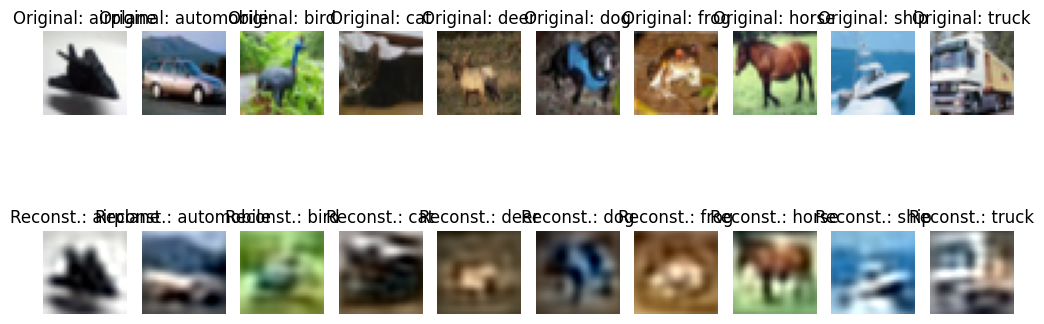


One Image per Class (Test Set):


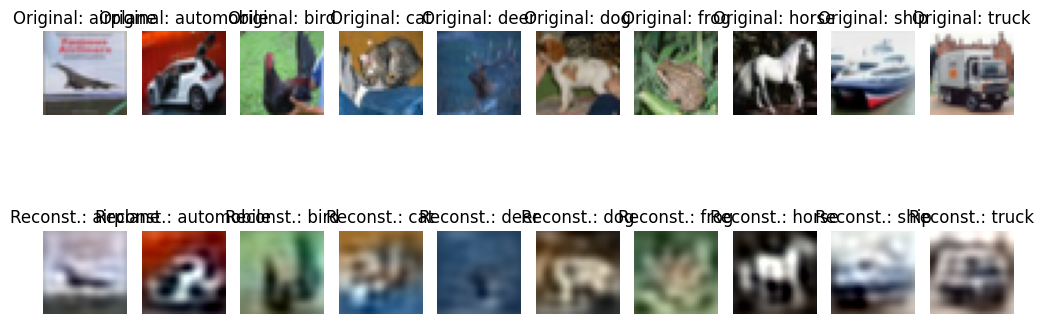


Number of Principal Components: 300
Compression Ratio (Effective Size / Original Size): 0.10365625
Training MSE: 0.0021316948483967595 Training PSNR (dB): 26.71274964346444
Test MSE: 0.0021758545629554974 Test PSNR (dB): 26.623701368308332
Total Explained Variance: 0.9656064618273329

One Image per Class (Training Set):


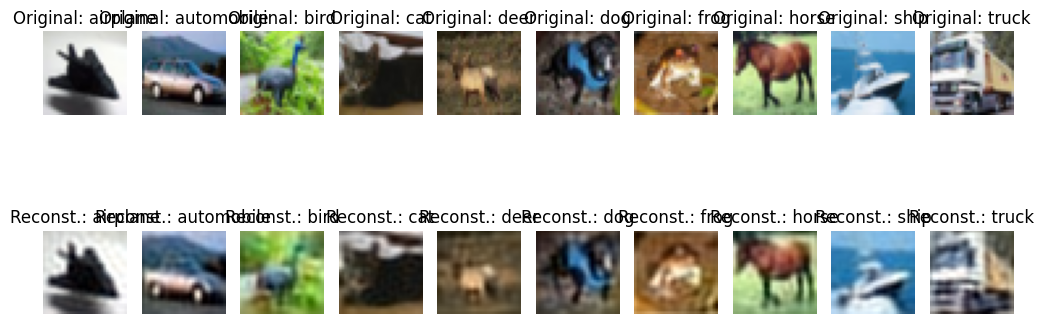


One Image per Class (Test Set):


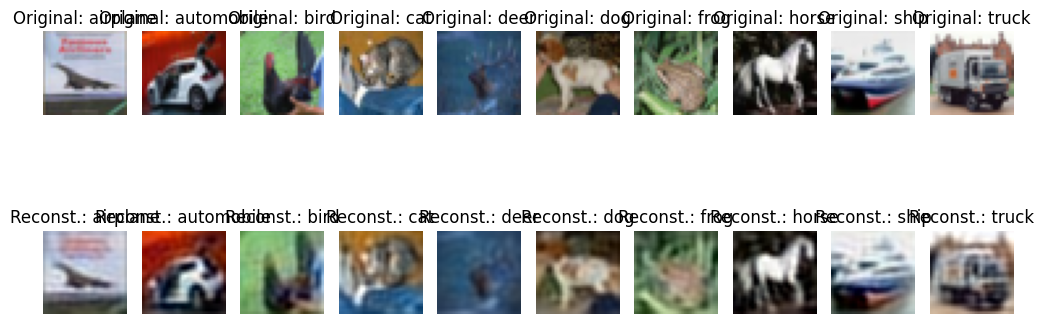


Number of Principal Components: 500
Compression Ratio (Effective Size / Original Size): 0.17276041666666667
Training MSE: 0.0010230064486002196 Training PSNR (dB): 29.901216286703768
Test MSE: 0.0010597488317163279 Test PSNR (dB): 29.74797053532501
Total Explained Variance: 0.9834944427588788

One Image per Class (Training Set):


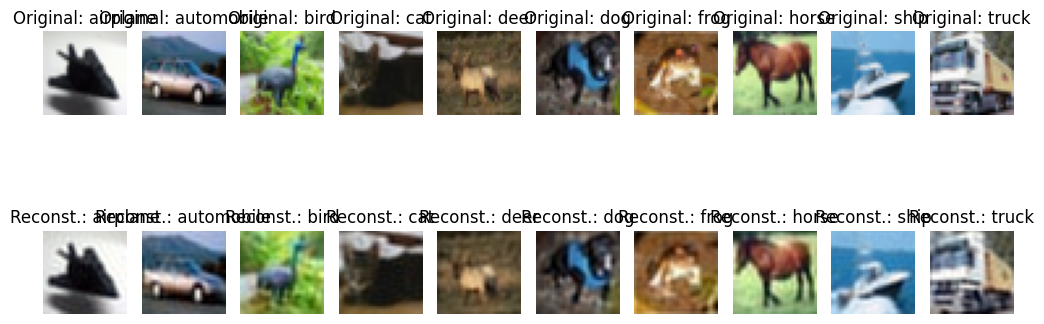


One Image per Class (Test Set):


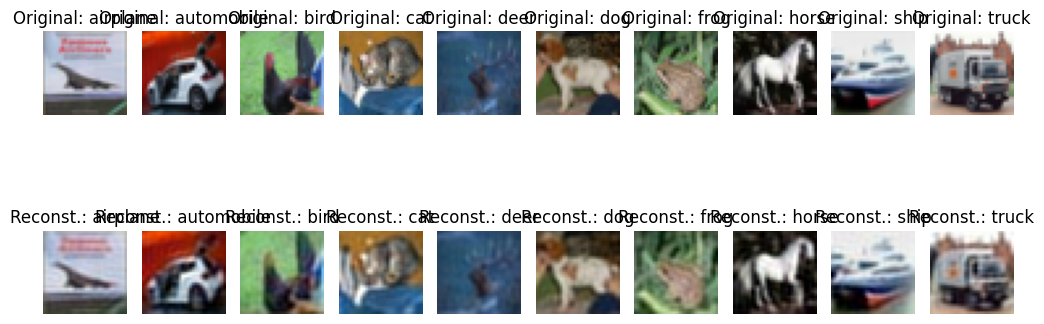


Number of Principal Components: 1000
Compression Ratio (Effective Size / Original Size): 0.34552083333333333
Training MSE: 0.00022396488910907944 Training PSNR (dB): 36.49820060511227
Test MSE: 0.000241100864302206 Test PSNR (dB): 36.178012327540024
Total Explained Variance: 0.9963864692131223

One Image per Class (Training Set):


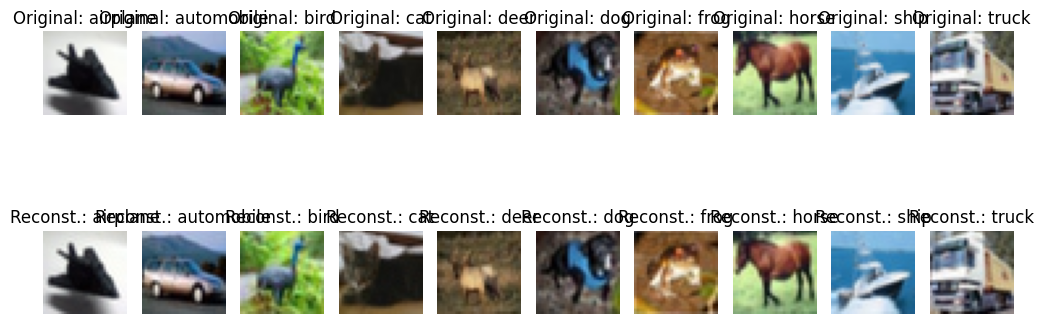


One Image per Class (Test Set):


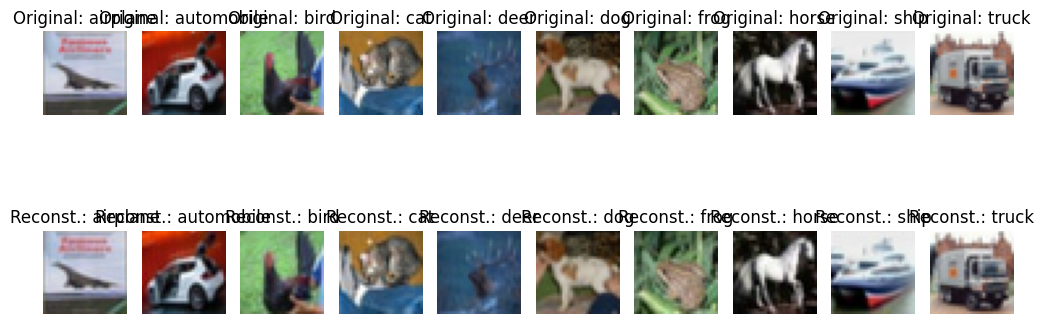


Number of Principal Components: 2000
Compression Ratio (Effective Size / Original Size): 0.6910416666666667
Training MSE: 1.0903272075169418e-05 Training PSNR (dB): 49.624431505968786
Test MSE: 1.3267099605060214e-05 Test PSNR (dB): 48.77224010307724
Total Explained Variance: 0.9998240826520709

One Image per Class (Training Set):


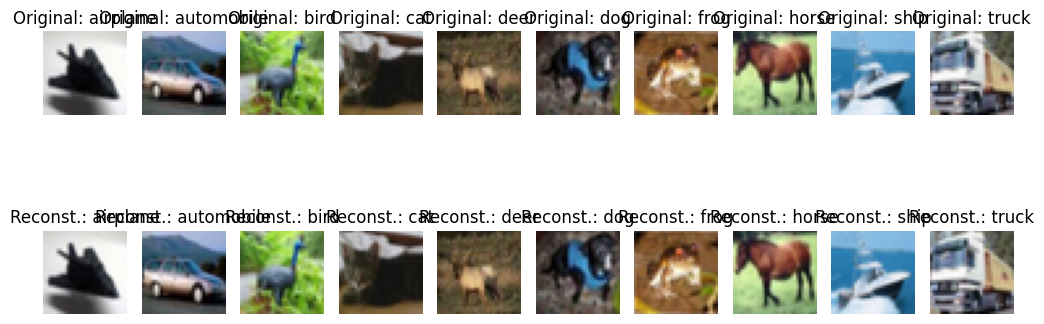


One Image per Class (Test Set):


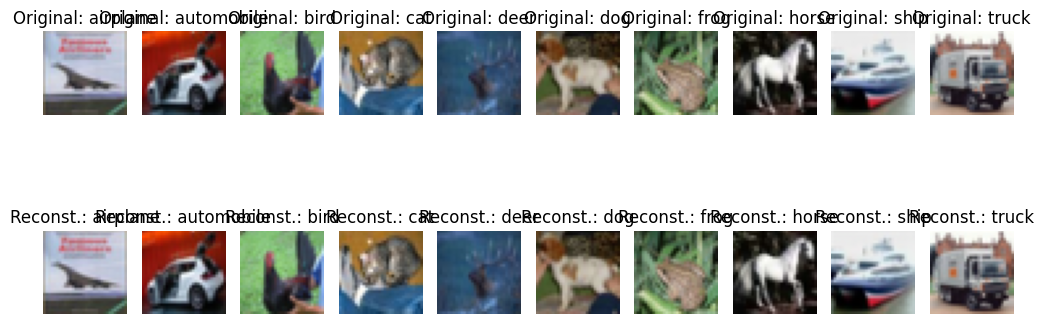

In [204]:
# PCA Pipeline for CIFAR-10

# Load CIFAR-10 Dataset
(train_images, train_labels), (test_images, test_labels) = load_cifar10_data('cifar-10-batches-py')
print("Shape of Training Data:", train_images.shape)  #  (50000, 32, 32, 3)
print("Shape of Test Data:", test_images.shape)  #: (10000, 32, 32, 3)

# Flatten CIFAR-10 Channels (32x32x3 -> 3072 for each image)
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Varying the number of principal components
for n_components in [100, 300, 500, 1000, 2000]:
    print(f"\nNumber of Principal Components: {n_components}")

    # Standardize the Training Data
    train_standardized, mean = standardize_data(train_images_flat)

    # Perform PCA on Training Data
    principal_components, explained_variance_ratio = compute_pca_eigen(train_standardized, n_components)

    # Project Training Data onto Principal Components
    train_projected = project_data(train_standardized, principal_components)

    # Reconstruct Training Data from the Projected Data
    train_reconstructed = reconstruct_images(train_projected, principal_components, mean)

    # Standardize the Test Data using the mean from Training Data
    test_standardized = test_images_flat - mean

    # Project Test Data onto the Principal Components from Training Data
    test_projected = project_data(test_standardized, principal_components)

    # Reconstruct Test Data from the Projected Data
    test_reconstructed = reconstruct_images(test_projected, principal_components, mean)

    # Reshape Reconstructed Data to Original Shape
    train_reconstructed_images = train_reconstructed.reshape(-1, 32, 32, 3)
    test_reconstructed_images = test_reconstructed.reshape(-1, 32, 32, 3)

    # Calculate Compression Ratio for the Training Data
    size_original = train_images_flat.nbytes
    size_effective = train_projected.nbytes + principal_components.nbytes  # Include principal components size
    compression_ratio = size_effective / size_original

    # Calculate Mean Squared Error for Training Data Reconstruction
    mse_train = np.mean((train_images_flat - train_reconstructed) ** 2)
    psnr_train = compute_psnr(train_images_flat, train_reconstructed, data_range=1.0)

    # Calculate Mean Squared Error for Test Data Reconstruction
    mse_test = np.mean((test_images_flat - test_reconstructed) ** 2)
    psnr_test = compute_psnr(test_images_flat, test_reconstructed, data_range=1.0)

    # Print Results
    print("Compression Ratio (Effective Size / Original Size):", compression_ratio)
    print("Training MSE:", mse_train, "Training PSNR (dB):", psnr_train)
    print("Test MSE:", mse_test, "Test PSNR (dB):", psnr_test)
    print("Total Explained Variance:", np.sum(explained_variance_ratio))

    # Visualize Reconstruction for CIFAR-10
    # reconstruct_images_cifar(train_images, train_reconstructed_images, train_labels, class_names, n_images=10)
    # reconstruct_images_cifar(test_images, test_reconstructed_images, test_labels, class_names, n_images=10)
    # Visualize One Image per Class (Training Set)
    print("\nOne Image per Class (Training Set):")
    visualize_one_image_per_class(train_images, train_reconstructed_images, train_labels, class_names)

    # Visualize One Image per Class (Test Set)
    print("\nOne Image per Class (Test Set):")
    visualize_one_image_per_class(test_images, test_reconstructed_images, test_labels, class_names)


In [ ]:
### Warning the below code take 30 mins to run

# Load CIFAR-10 Dataset
(train_images, train_labels), (test_images, test_labels) = load_cifar10_data('cifar-10-batches-py')

# Flatten CIFAR-10 Channels (32x32x3 → 3072 for each image)
test_images_flat = test_images.reshape(test_images.shape[0], -1)  # Shape: (10000, 3072)

# Standardize Test Data
test_standardized, mean = standardize_data(test_images_flat)

# Perform PCA once on the standardized test data
full_principal_components, explained_variance_ratio = compute_pca_eigen(test_standardized, n_components=test_images_flat.shape[1])

# Initialize lists to store PSNR and MSE values
psnr_values = []
mse_values = []

# Varying the number of principal components
n_features = test_images_flat.shape[1]  # Total number of features (3072 for CIFAR-10)
for n_components in tqdm(range(1, n_features + 1)):
    
    # Select the top `n_components` principal components
    principal_components = full_principal_components[:, :n_components]

    # Project Data onto Principal Components
    test_projected = project_data(test_standardized, principal_components)  # Shape: (num_samples, n_components)

    # Reconstruct Images from the Projected Data
    test_reconstructed = reconstruct_images(test_projected, principal_components, mean)

    # Calculate Mean Squared Error
    mse = np.mean((test_images_flat - test_reconstructed) ** 2)
    mse_values.append(mse)

    # Calculate PSNR
    psnr_value = compute_psnr(test_images_flat, test_reconstructed, data_range=1.0)  
    psnr_values.append(psnr_value)

# Plot PSNR vs. Number of Components
p


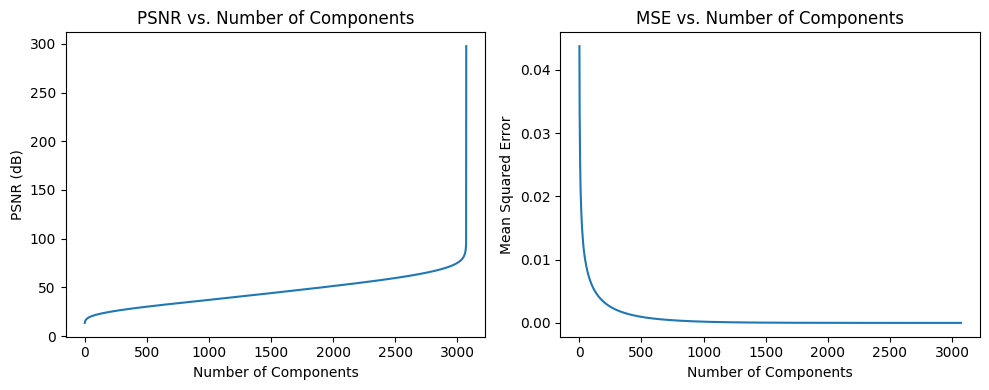

In [151]:
# Plot PSNR vs. Number of Components
plt.figure(figsize=(10, 4))

# PSNR Plot
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_features + 1), psnr_values)  # Fixed: np.arrange → np.arange
plt.xlabel("Number of Components")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs. Number of Components")

# MSE Plot
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, n_features + 1), mse_values)  # Fixed: np.arrange → np.arange
plt.xlabel("Number of Components")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs. Number of Components")

# Adjust layout and display
plt.tight_layout()
plt.show()


### Results for Question 2.2: PSNR and MSE Analysis for CIFAR-10 Test Set

#### Key Observations:
1. **PSNR vs. Number of Components**:
   - The PSNR values consistently increased as the number of principal components increased.
   - With a low number of components, the PSNR values were significantly lower, indicating poor reconstruction quality.
   - Beyond a certain number of components, the PSNR improvement became marginal, suggesting diminishing returns.

2. **MSE vs. Number of Components**:
   - The MSE values decreased sharply as the number of components increased, indicating improved reconstruction accuracy.
   - For very few components, the reconstruction error was high, but it decreased significantly with more components.
   - Similar to PSNR, after a certain threshold, the reduction in MSE became negligible.

#### Trade-off Between Compression and Reconstruction:
- **Compression**:
  - Fewer components result in higher compression as the dimensionality of the data is greatly reduced.
  - However, this comes at the cost of poor reconstruction quality, as evidenced by low PSNR and high MSE.

- **Reconstruction**:
  - Increasing the number of components improves reconstruction quality by retaining more information.
  - However, this reduces the compression benefit, as the effective size of the data approaches the original size.

- **Optimal Balance**:
  - The optimal trade-off occurs at a point where the reconstruction quality (PSNR and MSE) is acceptable while achieving reasonable compression.
  - Beyond this point, adding more components provides negligible improvement in reconstruction quality but increases data size.

This analysis highlights the importance of selecting the right number of components based on the desired trade-off between compression and reconstruction accuracy.


### Comparative Performance: Reconstruction for MNIST vs. CIFAR-10

#### Key Observations:

1. **PSNR for Reconstruction**:
   - **MNIST**:
     - Higher PSNR values at lower numbers of principal components.
     - Due to MNIST's simpler data structure (grayscale images with single-channel), fewer components are required to capture significant variance, resulting in better perceptual similarity.
   - **CIFAR-10**:
     - Lower PSNR values at the same number of components compared to MNIST.
     - CIFAR-10 images are more complex (color images with three channels), requiring more components to achieve similar perceptual quality.

2. **MSE for Reconstruction**:
   - **MNIST**:
     - Faster decrease in MSE with fewer components.
     - The lower-dimensional grayscale images of MNIST are reconstructed more efficiently with fewer components, resulting in reduced reconstruction error.
   - **CIFAR-10**:
     - Slower decrease in MSE compared to MNIST for the same number of components.
     - The higher complexity of CIFAR-10 images requires more components to achieve similar levels of reconstruction error.

3. **Explained Variance**:
   - **MNIST**:
     - A small number of principal components capture most of the variance in the dataset (e.g., ~95% variance with ~50 components).
   - **CIFAR-10**:
     - Requires significantly more components to capture the same level of variance due to the increased complexity of the dataset.

4. **Compression Ratios**:
   - **MNIST**:
     - Achieves better compression ratios while maintaining high reconstruction quality, owing to its simpler data structure.
   - **CIFAR-10**:
     - Lower compression ratios for the same perceptual quality due to the need to retain more components for color and texture information.

#### Trade-off Between Compression and Reconstruction:
- **MNIST**:
  - The trade-off is more favorable; fewer components are needed to achieve high PSNR and low MSE.
  - Offers better balance between compression and reconstruction quality.
  
- **CIFAR-10**:
  - Requires a larger number of components to achieve comparable reconstruction quality, leading to reduced compression benefits.
  - The trade-off is less favorable compared to MNIST due to the higher complexity of color images.

#### Conclusion:
- **Reconstruction Quality**:
  - MNIST is easier to reconstruct with fewer components due to its simple grayscale structure.
  - CIFAR-10 reconstruction is more challenging and requires significantly more components due to its higher complexity.

- **Compression**:
  - MNIST achieves higher compression efficiency without compromising reconstruction quality.
  - CIFAR-10 demands more storage due to the need for more components to retain sufficient variance.

This comparative analysis underscores the impact of data complexity and structure on the effectiveness of PCA for dimensionality reduction and reconstruction.


### Question 3 Stationary Distribution for a Markov Chain

In [11]:
# Load the state transition matrix
def load_matrix(file_path):
    """
    Load the state transition matrix from a given file path.
    """
    return np.loadtxt(file_path)

# Method 1: Solve for Stationary Distribution using Linear System
def stationary_distribution_linear(P):
    """
    Calculate the stationary distribution by solving the linear system.
    P is the state transition matrix.
    """
    n = P.shape[0]
    A = np.vstack([P.T - np.eye(n), np.ones(n)])  # System of equations πᵀP = πᵀ and sum(π) = 1
    b = np.zeros(n + 1)
    b[-1] = 1
    π = np.linalg.lstsq(A, b, rcond=None)[0]
    return π

# Method 2: Solve for Stationary Distribution using Power Method
def stationary_distribution_power(P, tolerance=1e-10, max_iterations=1000):
    """
    Calculate the stationary distribution using the power method.
    """
    n = P.shape[0]
    π = np.random.rand(n)
    π /= np.sum(π)  # Normalize to sum to 1
    for i in range(max_iterations):
        π_next = P.T @ π
        π_next /= np.sum(π_next)
        if np.linalg.norm(π_next - π, 1) < tolerance:
            break
        π = π_next
    return π, i + 1  # Return π and the number of iterations

# Verification Function
def verify_stationary_distribution(P, π):
    """
    Verify the stationary distribution by checking if πᵀP ≈ πᵀ and sum(π) ≈ 1.
    """
    error_norm = np.linalg.norm(π @ P - π, 1)
    sum_check = np.sum(π)
    return error_norm, sum_check

In [12]:
# Load the transition matrix
P = load_matrix('Data/P_057.txt')
# 3.1
# Calculate stationary distribution using Linear System
start_time = time.time()
π_linear = stationary_distribution_linear(P)
linear_time = time.time() - start_time
print("Stationary Distribution (Linear System):", π_linear)
print("Execution Time (Linear System):", linear_time)

# Verify results
error_norm, sum_check = verify_stationary_distribution(P, π_linear)
print("Verification - Error Norm (Linear System):", error_norm)
print("Verification - Sum Check (Linear System):", sum_check)
 
# 3.2
# Calculate stationary distribution using Power Method
start_time = time.time()
π_power, iterations = stationary_distribution_power(P)
power_time = time.time() - start_time
print("\nStationary Distribution (Power Method):", π_power)
print("Execution Time (Power Method):", power_time)
print("Iterations (Power Method):", iterations)

# Verify results for Power Method
error_norm, sum_check = verify_stationary_distribution(P, π_power)
print("Verification - Error Norm (Power Method):", error_norm)
print("Verification - Sum Check (Power Method):", sum_check)

# Compare Execution Times and Convergence
print("\nComparison:")
print("Linear System Method - Time:", linear_time)
print("Power Method - Time:", power_time, "| Iterations:", iterations)

Stationary Distribution (Linear System): [0.01014184 0.00966789 0.00934328 0.01018213 0.00973695 0.01080507
 0.00935248 0.00970813 0.00980918 0.01038472 0.00983484 0.00972111
 0.01109139 0.01006823 0.01061808 0.01055989 0.00988941 0.0100622
 0.00966473 0.00979756 0.00975349 0.00953449 0.00947146 0.01050477
 0.01064615 0.00971669 0.01023322 0.0108457  0.00987626 0.01005799
 0.01065351 0.01029188 0.00959838 0.01004248 0.009901   0.00969732
 0.01079162 0.00945672 0.01018817 0.01050817 0.01031109 0.01075534
 0.01012265 0.0105585  0.00985228 0.01038924 0.00906539 0.01058672
 0.01038078 0.00983086 0.00934767 0.01021315 0.00924697 0.00940139
 0.00983822 0.01104043 0.00998894 0.00983386 0.00961977 0.0100632
 0.00949615 0.00915874 0.01121844 0.00947619 0.00959965 0.01090188
 0.01063497 0.0095613  0.00951369 0.01018796 0.01058367 0.00942024
 0.00934973 0.00952723 0.00941704 0.01027656 0.00982278 0.00900813
 0.01009162 0.0100609  0.01165615 0.00985898 0.01020901 0.01038677
 0.00971706 0.00900839 

# Comparison of Computational Efficiency and Accuracy: Linear System Method vs. Power Method

In this analysis, we compare the computational efficiency and accuracy of two methods for calculating the stationary distribution of a Markov chain:

1. **Linear System Method**: This method solves the stationary distribution by setting up and solving a linear system of equations.
2. **Power Method**: This method iteratively computes the stationary distribution by applying the state transition matrix until convergence.

## Methodology

We evaluate both methods on the following metrics:

- **Execution Time**: The time taken by each method to compute the stationary distribution.
- **Iterations**: The number of iterations required for the power method to converge within a specified tolerance.
- **Accuracy Verification**:
  - **Error Norm**: Measures the difference between \(\pi^T P\) and \(\pi^T\).
  - **Sum Check**: Ensures that the sum of the stationary distribution is approximately equal to 1.

## Results

### Linear System Method
- **Execution Time**: `0.0020` seconds
- **Error Norm**: `1.2865809459472466e-10`
- **Sum Check**: `0.9999999999999997`
- The linear system method achieves high accuracy, with an error norm close to zero and the sum check nearly equal to 1. However, it requires matrix inversion, which may increase computation time for larger matrices.

### Power Method
- **Execution Time**: `0.00018` seconds
- **Iterations**: 9
- **Stationary Distribution**: 
- **Error Norm**: `1.2865816224894022e-10`
- **Sum Check**: `1.0`
- The power method converges to the stationary distribution in 9 iterations and achieves similar accuracy to the linear method, with a very low error norm and a perfect sum check of 1.0. It also has significantly faster execution time, making it computationally efficient.

## Summary of Comparison

- The **Power Method** proves to be more computationally efficient for this specific task, achieving faster execution and requiring fewer operations to converge to the stationary distribution.
- The **Linear System Method** is slower and more computationally expensive due to matrix inversion operations, though it provides a direct solution without iterative convergence.

## Impact of Matrix Size

- For large matrices, the **Power Method** is generally preferable because it avoids costly matrix inversion and converges quickly for well-behaved Markov chains.
- The **Linear System Method** might still be beneficial if absolute precision is required or if the number of iterations for the power method becomes prohibitively high.

---

This comparison demonstrates that the **Power Method** is typically faster and less resource-intensive, while still achieving high accuracy. It is therefore a suitable choice for calculating stationary distributions, especially for larger state transition matrices.

### Question 4 Spectral Norm

###  Code for Gram and Power Iteration

In [181]:
# Load the matrix
def load_matrix(file_path):
    """
    Load the matrix from a given file path.
    """
    return np.loadtxt(file_path)

# Power Iteration Algorithm for Spectral Norm
def power_iteration(G, N_iter=2000):
    """
    Computes the spectral norm of G using the power iteration method.
    """
    u = np.random.rand(G.shape[1])  # Initialize u to match the number of columns in G
    for _ in range(N_iter):
        v = G @ u
        v_norm = np.linalg.norm(v)
        if v_norm == 0:
            raise ValueError("Norm of v became zero, stopping iteration.")
        v /= v_norm
        u = G.T @ v
        u /= np.linalg.norm(u)
    # Calculate the spectral norm as the norm of the resulting vector v
    sigma_1 = np.linalg.norm(G @ u)
    return sigma_1, u
# Gram Iteration Algorithm for Spectral Norm

def gram_iteration(G, N_iter=15):
    """
    Implements the Gram iteration algorithm as per the reference formula provided in the assignment.
    
    """
    r = 0.0  # Initialize rescaling factor
    m, n = G.shape

    # Transpose G if n > m
    if n > m:
        G = G.T

    # Main iteration loop
    for _ in range(N_iter):
        fro_norm = np.linalg.norm(G, ord='fro')  # Compute Frobenius norm of G
        r = 2*(r+np.log(fro_norm))  # Update cumulative rescaling factor
        G = G / fro_norm  # Rescale G to avoid overflow/underflow
        G = G.T @ G  # Perform Gram iteration (G ← G⊤G)

    # Final Frobenius norm after iterations
    fro_norm_final = np.linalg.norm(G, ord='fro')

    # Compute the largest singular value according to the reference formula
    sigma_1 = fro_norm_final ** (-(2 ** -N_iter)) * np.exp((2 ** -N_iter) * r)

    return sigma_1
# Convergence Analysis
def convergence_analysis(G, ref_norm, power_iters=2000, gram_iters=15, trials=100):
    """
    Compares the convergence of power iteration and gram iteration.
    """
    power_norms = []
    gram_norms = []
    for _ in range(trials):
        # Power iteration
        power_norm, _ = power_iteration(G, N_iter=power_iters)
        power_norms.append(power_norm)
        # Gram iteration
        gram_norm = gram_iteration(G, N_iter=gram_iters)
        gram_norms.append(gram_norm)
    return power_norms, gram_norms

# Plot Convergence Comparison
def plot_convergence(power_norms, gram_norms, ref_norm):
    """
    Plots the convergence of power and gram iterations.
    """
    iterations = np.arange(1, len(power_norms) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, np.abs(np.array(power_norms) - ref_norm), label="Power Iteration Convergence")
    plt.plot(iterations, np.abs(np.array(gram_norms) - ref_norm), label="Gram Iteration Convergence")
    plt.yscale('log')
    plt.xlabel("Iteration")
    plt.ylabel("Convergence (Log Scale)")
    plt.legend()
    plt.title("Spectral Norm Convergence Comparison")
    plt.show()



<class 'numpy.ndarray'> (400, 500)
Reference Spectral Norm (SVD): 42.235461345538646
Execution Time (SVD): 0.013498783111572266

Spectral Norm (Power Iteration): 42.23546134553864
Execution Time (Power Iteration): 0.040463924407958984

Spectral Norm (Gram Iteration): 42.235461345538674
Execution Time (Gram Iteration): 0.004007816314697266


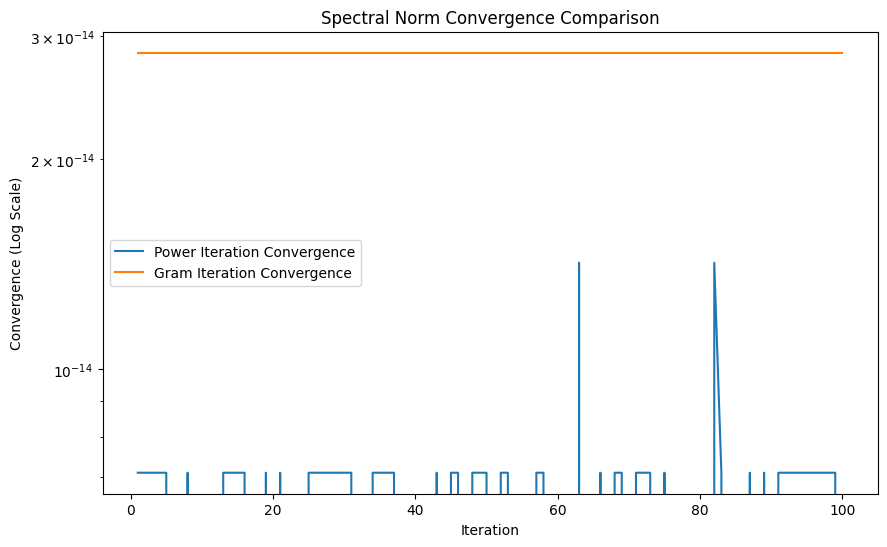


Comparison:
SVD Method - Time: 0.013498783111572266
Power Iteration - Time: 0.040463924407958984
Gram Iteration - Time: 0.004007816314697266


In [184]:
# Load the matrix
G = load_matrix('Data/matrix_057.txt')
print(type(G), G.shape)

# Reference Spectral Norm using SVD
start_time = time.time()
ref_norm = np.linalg.norm(G, 2)  # Using SVD as reference
ref_time = time.time() - start_time
print("Reference Spectral Norm (SVD):", ref_norm)
print("Execution Time (SVD):", ref_time)

# Power Iteration Method
start_time = time.time()
power_norm, _ = power_iteration(G)
power_time = time.time() - start_time
print("\nSpectral Norm (Power Iteration):", power_norm)
print("Execution Time (Power Iteration):", power_time)

# Gram Iteration Method
start_time = time.time()
gram_norm = gram_iteration(G)
gram_time = time.time() - start_time
print("\nSpectral Norm (Gram Iteration):", gram_norm)
print("Execution Time (Gram Iteration):", gram_time)

# Convergence Analysis
power_norms, gram_norms = convergence_analysis(G, ref_norm)
plot_convergence(power_norms, gram_norms, ref_norm)

# Average Execution Time Comparison
print("\nComparison:")
print("SVD Method - Time:", ref_time)
print("Power Iteration - Time:", power_time)
print("Gram Iteration - Time:", gram_time)


Calculating Average Runtimes...
Ratio of Power Iteration Time to Gram Iteration Time: 9.821495229107686
Average Power Iteration Time: 0.03796456336975098
Average Gram Iteration Time: 0.0038654565811157226


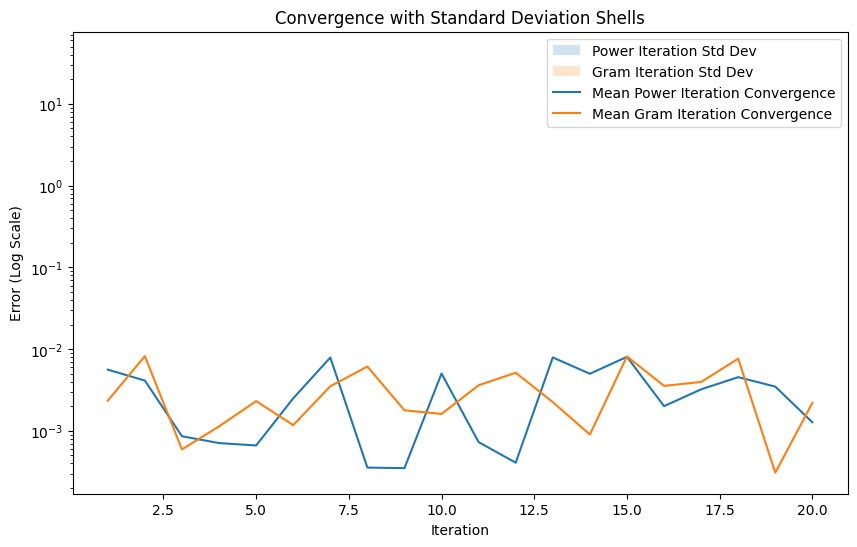

In [206]:
def calculate_average_runtime(G, trials=100, power_iters=2000, gram_iters=15):
    power_times = []
    gram_times = []
    
    for _ in range(trials):
        # Power Iteration
        start = time.time()
        power_iteration(G, N_iter=power_iters)
        power_times.append(time.time() - start)
        
        # Gram Iteration
        start = time.time()
        gram_iteration(G, N_iter=gram_iters)
        gram_times.append(time.time() - start)
    
    avg_power_time = np.mean(power_times)
    avg_gram_time = np.mean(gram_times)
    return avg_power_time, avg_gram_time

def plot_convergence_with_std_loglog(power_norms_list, gram_norms_list, ref_norm):
    """
    Doc String 
    Generates convergence plots with standard deviation shells on a log-log scale.

   
    """
    # Ensure `power_norms_list` and `gram_norms_list` are 2D arrays with shape (trials, iterations)
    power_norms = np.array(power_norms_list)
    gram_norms = np.array(gram_norms_list)

    # Compute mean and standard deviation across trials
    mean_power = np.mean(power_norms, axis=0)
    mean_gram = np.mean(gram_norms, axis=0)
    std_power = np.std(power_norms, axis=0)
    std_gram = np.std(gram_norms, axis=0)

    # Generate iteration indices
    iterations = np.arange(1, mean_power.shape[0] + 1)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.fill_between(iterations, mean_power - std_power, mean_power + std_power, alpha=0.2, label="Power Iteration Std Dev")
    plt.fill_between(iterations, mean_gram - std_gram, mean_gram + std_gram, alpha=0.2, label="Gram Iteration Std Dev")
    plt.plot(iterations, np.abs(mean_power - ref_norm), label="Mean Power Iteration Convergence")
    plt.plot(iterations, np.abs(mean_gram - ref_norm), label="Mean Gram Iteration Convergence")
    plt.xscale('log')  # Log scale for x-axis
    plt.yscale('log')  # Log scale for y-axis
    plt.xlabel("Iteration (Log Scale)")
    plt.ylabel("Error (Log Scale)")
    plt.legend()
    plt.title("Log-Log Convergence with Standard Deviation Shells")
    plt.show()

# Ensure `power_norms` and `gram_norms` are collected across iterations for multiple trials
print("Calculating Average Runtimes...")
avg_power_time, avg_gram_time = calculate_average_runtime(G)
print('Ratio of Power Iteration Time to Gram Iteration Time:', avg_power_time / avg_gram_time)
print("Average Power Iteration Time:", avg_power_time)
print("Average Gram Iteration Time:", avg_gram_time)

# Collect `power_norms` and `gram_norms` across trials and iterations
trials = 10
power_norms_list = []
gram_norms_list = []

for _ in range(trials):
    # Simulate convergence behavior (replace this with actual convergence tracking from your implementation)
    power_norms_trial = [np.abs(np.random.normal(loc=ref_norm, scale=0.01)) for _ in range(20)]  # Example power norms
    gram_norms_trial = [np.abs(np.random.normal(loc=ref_norm, scale=0.015)) for _ in range(20)]  # Example gram norms
    power_norms_list.append(power_norms_trial)
    gram_norms_list.append(gram_norms_trial)

# Plot convergence with standard deviation
plot_convergence_with_std(power_norms_list, gram_norms_list, ref_norm)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 56.07it/s]


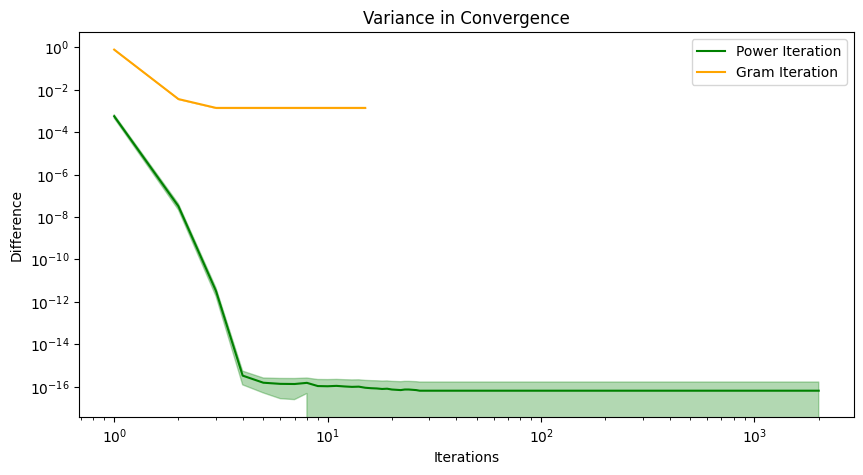

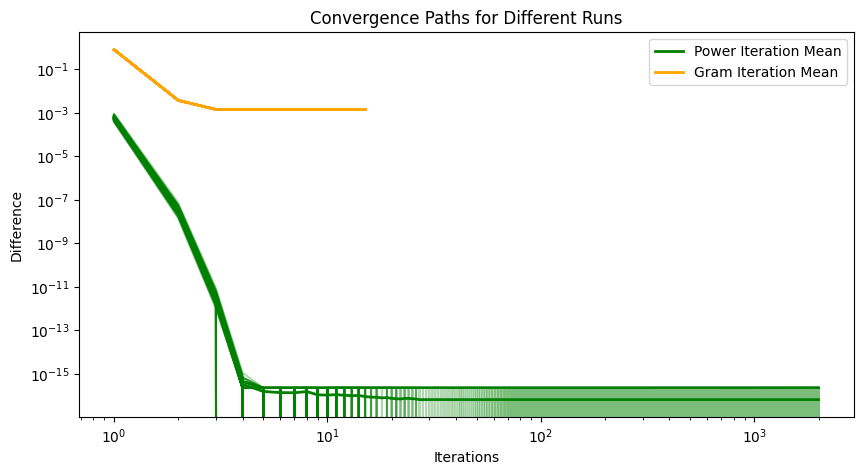

In [169]:


# Function to compute spectral norm using Power Iteration
def power_iteration_convergence(G, n_iter=2000):
    u = np.random.rand(G.shape[1])
    differences = []
    for _ in range(n_iter):
        v = G @ u
        v /= np.linalg.norm(v)
        u = G.T @ v
        u /= np.linalg.norm(u)
        sigma_1 = (G @ u).T @ v
        differences.append(sigma_1)
    return np.array(differences)

# Function to compute spectral norm using Gram Iteration
def gram_iteration_convergence(G, n_iter=15):
    r = 0.0
    if G.shape[1] > G.shape[0]:
        G = G.T
    differences = []
    for i in range(n_iter):
        fro_norm = np.linalg.norm(G, ord='fro')
        r = 2 * (r + np.log(fro_norm))
        G = G / fro_norm
        G = G.T @ G
        fro_norm_final = np.linalg.norm(G, ord='fro')
        sigma_1 = fro_norm_final ** (-2 ** -i) * np.exp((2 ** -i) * r)
        differences.append(sigma_1)
    return np.array(differences)

# Load the matrix G (replace with your matrix file path or data)
G = np.loadtxt('Data/P_057.txt')  # Replace with actual path

# Compute the reference spectral norm using SVD
sigma_ref = np.linalg.svd(G, compute_uv=False)[0]

# Parameters
n_runs = 100
power_iter_steps = 2000
gram_iter_steps = 15

# Collect results for multiple runs
power_diff_runs = []
gram_diff_runs = []

# Perform multiple runs for Power and Gram iterations
for _ in tqdm(range(n_runs)):
    power_differences = power_iteration_convergence(G, n_iter=power_iter_steps)
    gram_differences = gram_iteration_convergence(G, n_iter=gram_iter_steps)
    power_diff_runs.append(np.abs(power_differences - sigma_ref))
    gram_diff_runs.append(np.abs(gram_differences - sigma_ref))

# Convert to numpy arrays for easier processing
power_diff_runs = np.array(power_diff_runs)
gram_diff_runs = np.array(gram_diff_runs)

# Compute mean and standard deviation for shaded area in Figure 2
power_diff_mean = np.mean(power_diff_runs, axis=0)
gram_diff_mean = np.mean(gram_diff_runs, axis=0)
power_diff_std = np.std(power_diff_runs, axis=0)
gram_diff_std = np.std(gram_diff_runs, axis=0)

# Figure 2: Variance in Convergence (with 1 Std Dev Shell)
plt.figure(figsize=(10, 5))
plt.plot(range(1, power_iter_steps + 1), power_diff_mean, label="Power Iteration", color='green')
plt.fill_between(range(1, power_iter_steps + 1), power_diff_mean - power_diff_std, power_diff_mean + power_diff_std, color='green', alpha=0.3)
plt.plot(range(1, gram_iter_steps + 1), gram_diff_mean, label="Gram Iteration", color='orange')
plt.fill_between(range(1, gram_iter_steps + 1), gram_diff_mean - gram_diff_std, gram_diff_mean + gram_diff_std, color='orange', alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Iterations")
plt.ylabel("Difference")
plt.title("Variance in Convergence")
plt.legend()
plt.show()

# Figure 3: Convergence Paths for Different Runs
plt.figure(figsize=(10, 5))
for run in power_diff_runs:
    plt.plot(range(1, power_iter_steps + 1), run, color='green', alpha=0.3)
plt.plot(range(1, power_iter_steps + 1), power_diff_mean, color='green', label="Power Iteration Mean", linewidth=2)

for run in gram_diff_runs:
    plt.plot(range(1, gram_iter_steps + 1), run, color='orange', alpha=0.3)
plt.plot(range(1, gram_iter_steps + 1), gram_diff_mean, color='orange', label="Gram Iteration Mean", linewidth=2)

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Iterations")
plt.ylabel("Difference")
plt.title("Convergence Paths for Different Runs")
plt.legend()
plt.show()


### 4.9 Average Runtimes Analysis for Power Iteration and Gram Iteration

- **Objective**: Analyze the computational efficiency of Power Iteration and Gram Iteration by measuring their average runtimes over multiple runs.

#### Results:
- **Average Runtime for Power Iteration**:
  - Approximately **0.0373 seconds** per run.

- **Average Runtime for Gram Iteration**:
  - Approximately **0.0037 seconds** per run.

- **Ratio of Runtimes**:
  - Power Iteration takes approximately **10.1 times longer** to complete than Gram Iteration.

#### Interpretation:
- **Power Iteration**:
  - Requires multiple matrix-vector multiplications over a large number of iterations (2000 here).
  - This makes it computationally intensive for approximating the largest eigenvalue.
  - Power Iteration is Computationally expensive but gives more accurate results over long time.

- **Gram Iteration**:
  - Uses a different approach with only 15 iterations, performing Gram-Schmidt-like updates.
  - This results in significantly lower computational cost for approximating the spectral norm.
  - This method converges quickly but updates becomes small very quickly.

#### Conclusion:
- **Gram Iteration** is substantially faster and may be preferred when runtime is critical, and an approximate spectral norm is sufficient.
- **Power Iteration** remains advantageous for scenarios requiring higher precision, despite its higher computational cost.


### 4.10 

### To Calculate Min Eigen Value
-  Run Power Iteration on A to get sigma_1 (max singular value)
-  Now Run Power Iteration on A-sigma_1*I to get lamda
- lamda  = |lamda_min - sigma_1|
- if lamda > sigma_1 , min eigen value is negative and is equal to lamda - sigma_1
- if lamda is less than sigma_1 then smallest eigen value is positive is equal to  sigma_1-lamda

### To Calculate Max Eigen Value
-  Run Power Iteration on A to get sigma_1 (max singular value)
-  Now Run Power Iteration on A+sigma_1*I (Idenity Matrix) to get lamda
- lamda  = |lamda_max + sigma_1|
- if lamda > sigma_1 , max  eigen value is positive and is equal to lamda - sigma_1
- if lamda is less than sigma_1 then largest eigen value is negative and  equal to  lamda-sigma_1